In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.rcParams["figure.dpi"] = 150

DATASETS = ["hotpotqa", "multihoprag", "musique"]
result_dir_path = Path("../results")
result_path = result_dir_path / "summary.csv"
sns.set_theme(style="whitegrid")


def load_result_df(path: Path, overwrite: bool = False) -> pd.DataFrame:
    if path.exists() and not overwrite:
        return pd.read_csv(path)
    df = create_result_summary(path.parent)
    df.to_csv(path, index=False)
    return df


def create_result_summary(result_dir: Path) -> pd.DataFrame:
    def sort_key(methods: pd.Series) -> pd.Series:
        method_order = [
            "norag",
            "oneshotrag",
            "ircot",
            "react",
            "scr",
            "totr",
            "oracle",
        ]
        keys = {method: i for i, method in enumerate(method_order)}
        return methods.map(keys)

    result_df = pd.DataFrame()
    for dataset in DATASETS:
        result_files = result_dir.joinpath(dataset).glob("*_metrics.json")
        result_dict = {
            "Method": [],
            "Model": [],
            "Prompting": [],
            "Exact Match": [],
            "F1": [],
            "Precision": [],
            "Recall": [],
        }

        for result_file in result_files:
            with open(result_file, "r") as f:
                result = json.load(f)
            method, model, prompting, _ = result_file.stem.split("_")
            result_dict["Method"].append(method)
            result_dict["Model"].append(model)
            result_dict["Prompting"].append(prompting)
            result_dict["Exact Match"].append(result["em"])
            result_dict["F1"].append(result["f1"])
            result_dict["Precision"].append(result["prec"])
            result_dict["Recall"].append(result["recall"])
        dataset_df = pd.DataFrame(result_dict)
        dataset_df["Dataset"] = dataset
        result_df = pd.concat([result_df, dataset_df], ignore_index=True)
        result_df = result_df[["Dataset", *result_dict]]

    result_df.sort_values("Method", key=sort_key, inplace=True)
    result_df.sort_values(["Dataset", "Model", "Prompting"], inplace=True)

    name_map = {
        "oracle": "Oracle",
        "norag": "NoRAG",
        "oneshotrag": "OneRAG",
        "ircot": "IRCoT",
        "react": "ReAct",
        "scr": "SCR",
        "totr": "ToTR",
    }
    result_df["Method"] = result_df["Method"].map(name_map)

    name_map = {
        "hotpotqa": "HotpotQA",
        "multihoprag": "MultiHop-RAG",
        "musique": "MuSiQue",
    }
    result_df["Dataset"] = result_df["Dataset"].map(name_map)
    return result_df

In [ ]:
result_df = load_result_df(result_path)
result_df.head()

,Dataset,Method,Model,Prompting,Exact Match,F1,Precision,Recall
0,HotpotQA,NoRAG,Llama-3.1-8B-Instruct,cot,0.310,0.392690,0.416167,0.386833
10,HotpotQA,OneRAG,Llama-3.1-8B-Instruct,cot,0.380,0.492705,0.525833,0.486250
1,HotpotQA,IRCoT,Llama-3.1-8B-Instruct,cot,0.460,0.577686,0.609750,0.572310
11,HotpotQA,ReAct,Llama-3.1-8B-Instruct,cot,0.370,0.457678,0.479897,0.461893
9,HotpotQA,SCR,Llama-3.1-8B-Instruct,cot,0.495,0.613774,0.644417,0.608643


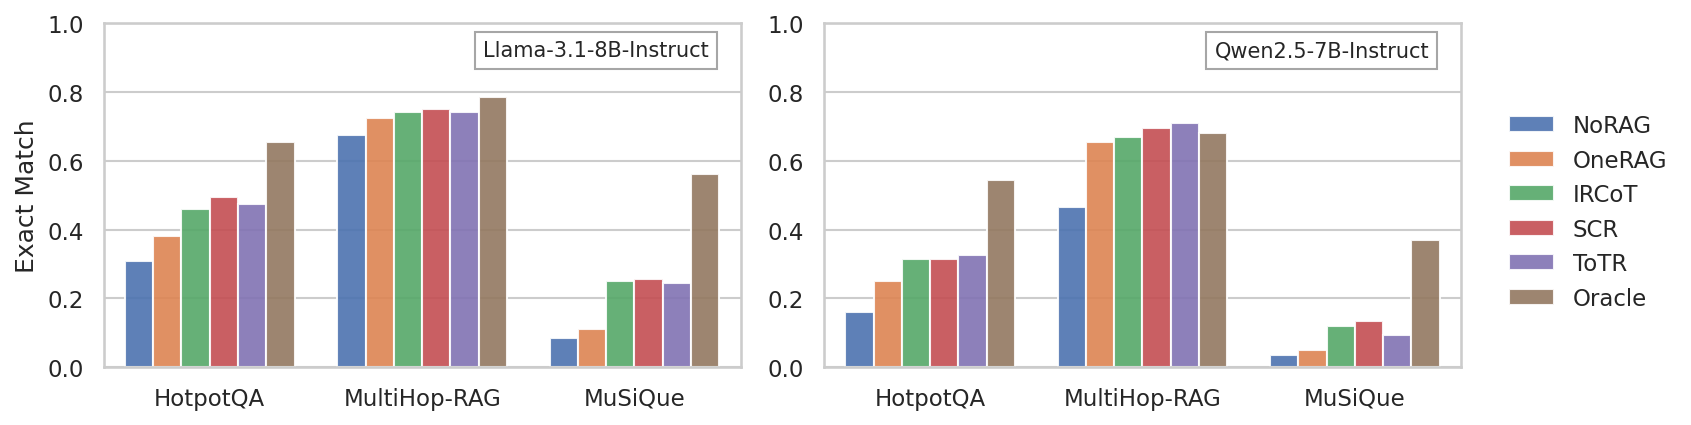

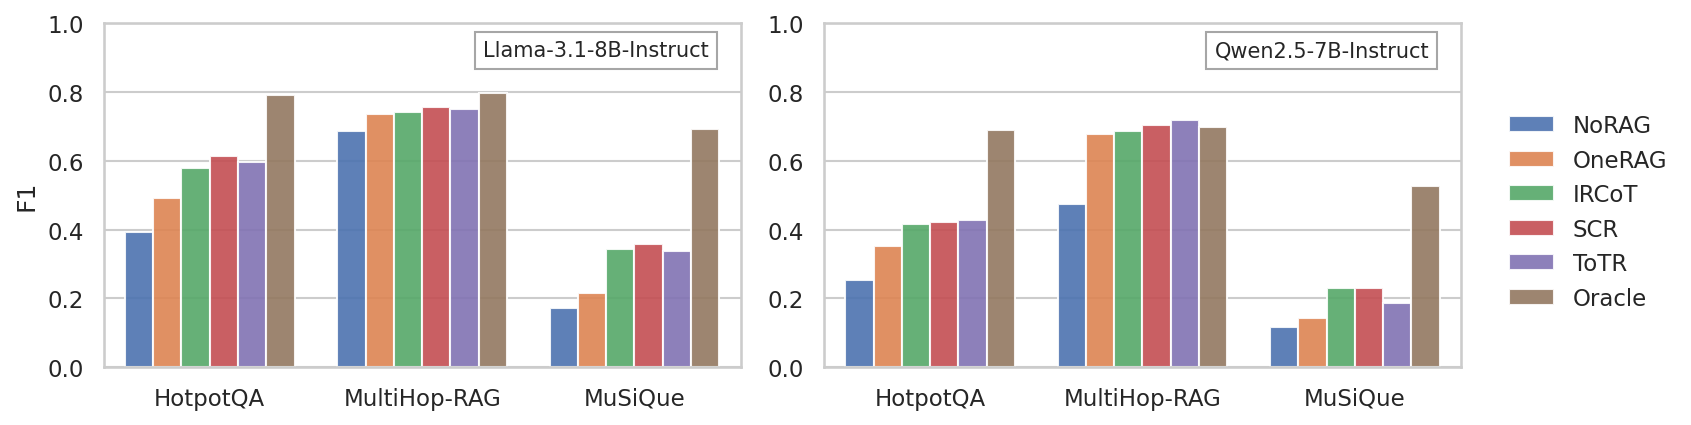

In [3]:
models = result_df["Model"].unique()
metrics = ["Exact Match", "F1"]
for metric in metrics:
    fig, axs = plt.subplots(1, len(models), figsize=(5 * len(models), 3))

    legend_handles = None
    legend_labels = None

    for i, (ax, model) in enumerate(zip(axs, models)):
        model_df = result_df[result_df["Model"] == model]
        model_df = model_df[model_df["Method"] != "ReAct"]
        g = sns.barplot(
            model_df,
            x="Dataset",
            y=metric,
            hue="Method",
            alpha=0.9,
            saturation=1,
            ax=ax,
        )
        g.set_xlabel("")
        if i != 0:
            g.set_ylabel("")
        g.set_ylim(0, 1)

        ax.text(
            0.95, 0.95, model,
            transform=ax.transAxes,
            ha="right", va="top",
            fontsize=10, bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray")
        )

        legend_handles, legend_labels = ax.get_legend_handles_labels()
        ax.legend_.remove()

    if legend_handles and legend_labels:
        fig.legend(
            legend_handles,
            legend_labels,
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            frameon=False,
        )
    plt.tight_layout()
    plt.show()

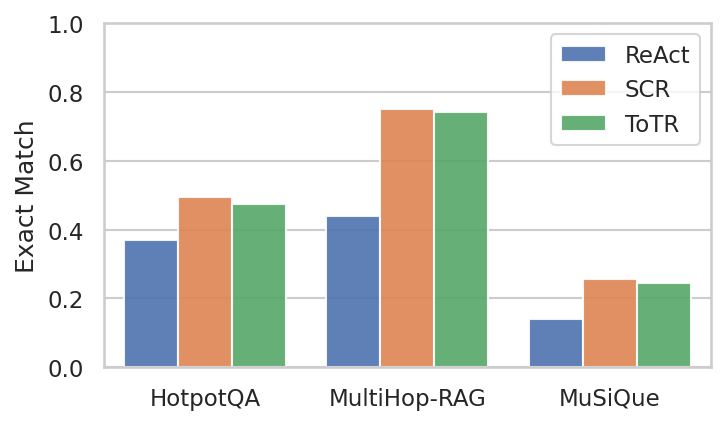

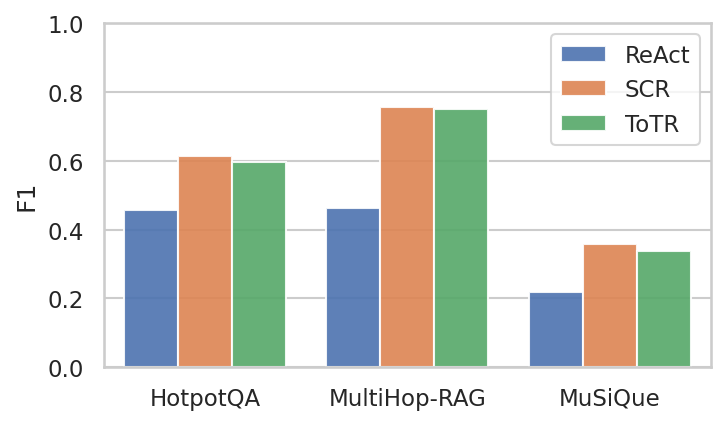

In [4]:
model = "Llama-3.1-8B-Instruct"
metrics = ["Exact Match", "F1"]
for metric in metrics:
    fig, ax = plt.subplots(figsize=(5, 3))
    model_df = result_df[result_df["Model"] == model]
    model_df = model_df[model_df["Method"].isin(["ReAct", "SCR", "ToTR"])]

    g = sns.barplot(
        model_df,
        x="Dataset",
        y=metric,
        hue="Method",
        alpha=0.9,
        saturation=1,
        ax=ax,
    )
    g.set_xlabel("")
    g.set_ylim(0, 1)
    assert g.legend_ is not None
    g.legend_.set_title("")

    plt.tight_layout()
    plt.show()

# Ablation

## Varying the number of paths

In [5]:
result_dir = result_dir_path / "hotpotqa_ablation_num_paths"
result_files = result_dir.glob("*_metrics.json")

In [6]:
result_dict = {
    "Model": [],
    "Number of paths": [],
    "Exact Match": [],
    "F1": [],
}
for result_file in result_files:
    with open(result_file, "r") as f:
        result = json.load(f)
    method, model, prompting, num_paths_str, _ = result_file.stem.split("_")
    num_paths = int(num_paths_str[:-len("paths")])
    result_dict["Model"].append(model)
    result_dict["Number of paths"].append(num_paths)
    result_dict["Exact Match"].append(result["em"])
    result_dict["F1"].append(result["f1"])
ablation_df = pd.DataFrame(result_dict).sort_values("Model")
ablation_df.head()

,Model,Number of paths,Exact Match,F1
1,Llama-3.1-8B-Instruct,11,0.480,0.594381
4,Llama-3.1-8B-Instruct,8,0.495,0.620829
6,Llama-3.1-8B-Instruct,3,0.480,0.595847
8,Llama-3.1-8B-Instruct,15,0.480,0.598329
9,Llama-3.1-8B-Instruct,5,0.505,0.623746


In [7]:
model_name_map = {"Llama-3.1-8B-Instruct": "Llama", "Qwen2.5-7B-Instruct": "Qwen"}
reversed_model_map = {v: k for k, v in model_name_map.items()}
ablation_df["Model"] = ablation_df["Model"].map(model_name_map)

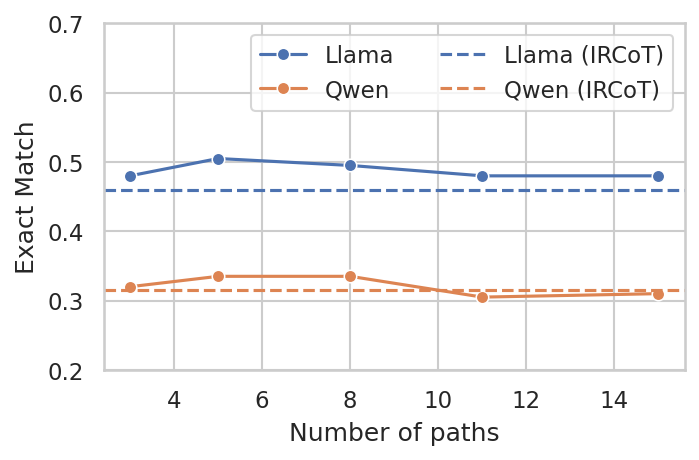

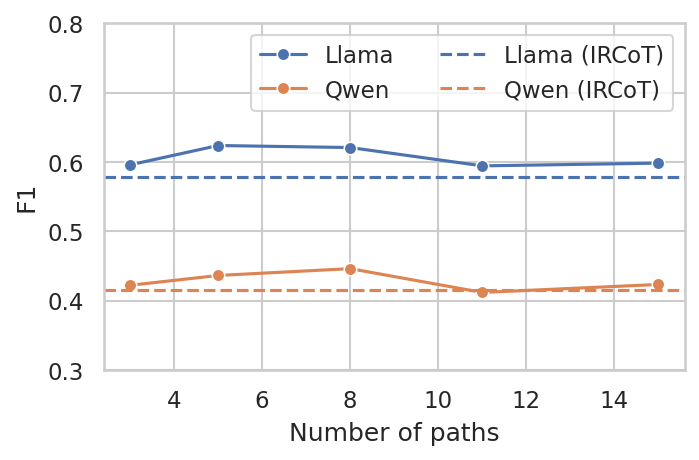

In [8]:
metrics = {
    "Exact Match": (0.2, 0.7),
    "F1": (0.3, 0.8),
}
for metric, (ymin, ymax) in metrics.items():
    plt.figure(figsize=(5, 3))

    g = sns.lineplot(
        data=ablation_df, x="Number of paths", y=metric, hue="Model", marker="o"
    )
    models = ablation_df["Model"].unique()
    lines = []
    for i, model in enumerate(models):
        baseline_score = (
            result_df.set_index(["Dataset", "Method", "Model"])
            .loc[("HotpotQA", "IRCoT", reversed_model_map[model]), :][metric]
            .item()
        )
        lines.append(
            g.axhline(baseline_score, linestyle="--", color=g.get_lines()[i].get_color())
        )
    g.set_ylim(ymin, ymax)

    handles, labels = g.get_legend_handles_labels()
    for line, model in zip(lines, models):
        handles.append(line)
        labels.append(model + " (IRCoT)")
    assert g.legend_ is not None
    g.legend_.remove()
    g.legend(handles=handles, labels=labels, title="", ncol=2)

    plt.show()